In [4]:
import pandas as pd
import numpy as np

# https://thecleverprogrammer.com/2022/06/21/time-series-forecasting-with-arima/
# https://thecleverprogrammer.com/2020/08/29/time-series-with-lstm-in-machine-learning/
# https://neptune.ai/blog/arima-vs-prophet-vs-lstm
# https://towardsdatascience.com/lstm-framework-for-univariate-time-series-prediction-d9e7252699e

In [5]:
#IMAGES_PATH = "E:\page ds\pages\ts_covid19"  # lub "."  jeżeli plik będzie w tym samym folderze
data_path = "E:/page ds/pages/ts_covid19/covid19_dane.csv" 
Covid19 = pd.read_csv(data_path)
display(Covid19)



,Data,Nowe.przypadki,Zgony
0,2020-03-03,0,0
1,2020-03-04,1,0
2,2020-03-05,0,0
3,2020-03-06,4,0
4,2020-03-07,1,0
...,...,...,...
871,2022-07-22,2544,3038
872,2022-07-23,2942,3493
873,2022-07-24,562,642
874,2022-07-25,523,589


Pozostawiam jedynie kolumnę z nowymi przypadkami oraz kasuję pierwsze miesiące danych gdzie nie był kompleyny lockdown (dokładnie oddcinam się do danych od sierpnia 2020).
Dzielę również zbiór na część testową oraz walidacyjną


In [6]:
Covid19 = Covid19[['Data','Nowe.przypadki']] 
Covid19 = Covid19[Covid19['Data'] > '2020-07-30']

Covid19_Train = Covid19[Covid19['Data'] <= '2022-07-12']
Covid19_Test = Covid19[Covid19['Data'] > '2022-07-12']


(array([  0.,  31.,  59.,  90., 120., 151., 181., 212., 243., 273., 304.,
        334., 365., 396., 424., 455., 485., 516., 546., 577., 608., 638.,
        669., 699.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

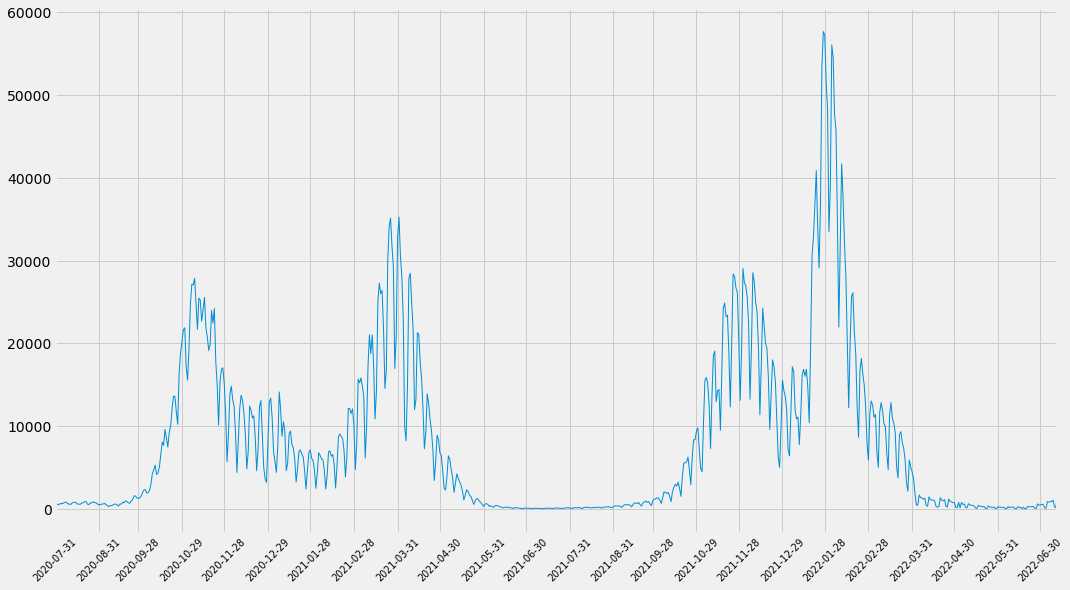

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates


plt.style.use('fivethirtyeight')

plt.figure(figsize=(16, 9))
plt.plot("Data", "Nowe.przypadki",data = Covid19_Train, linewidth = 1)

# round to nearest years.
datemin = np.min(Covid19_Train["Data"])
datemax = np.max(Covid19_Train["Data"])
plt.xlim(datemin, datemax)

# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, fontweight='light',  fontsize='x-small')



C:\Users\krzys\AppData\Local\Temp/ipykernel_3360/2599757843.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(Covid19_Train["Nowe.przypadki"],


<Figure size 432x288 with 0 Axes>

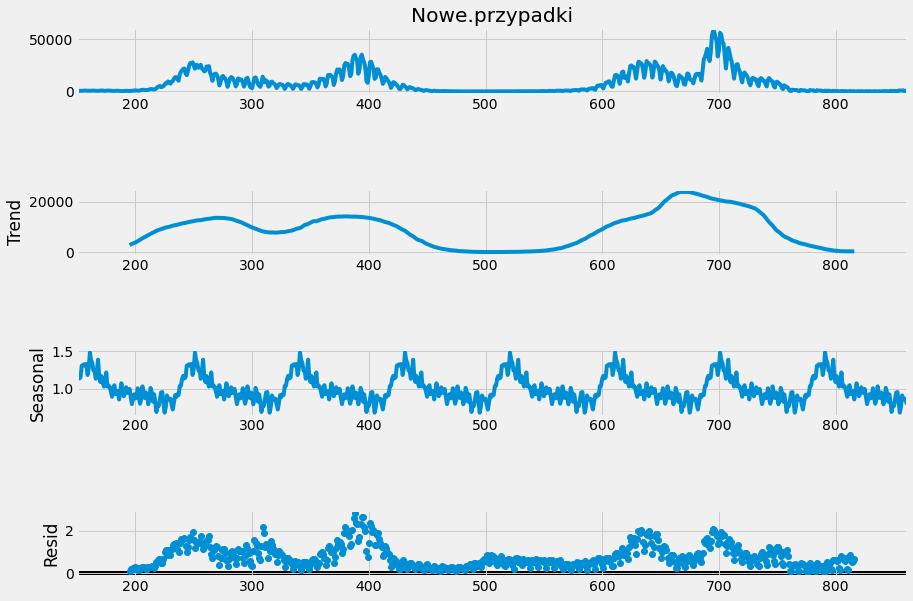

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
Covid19_Train.sort_index(inplace=True)

result = seasonal_decompose(Covid19_Train["Nowe.przypadki"], 
                            model='multiplicative', freq = 90)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)
#fig.set_linewidth(0.5)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

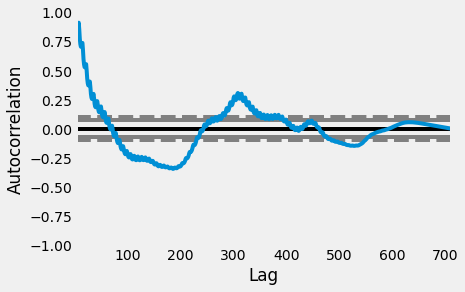

In [35]:
pd.plotting.autocorrelation_plot(Covid19_Train["Nowe.przypadki"])


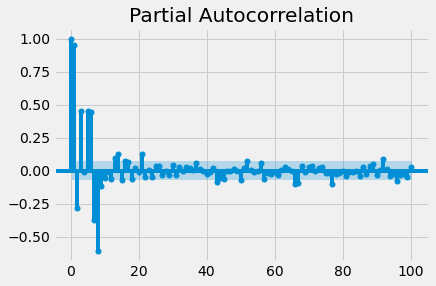

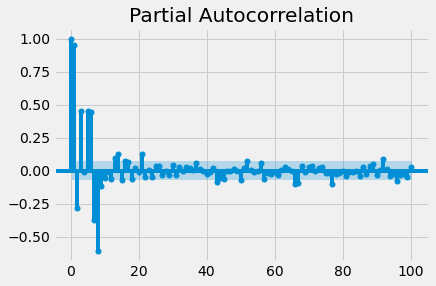

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(Covid19_Train["Nowe.przypadki"], lags = 100)

### Tworzenie prognozy za pommocą sieci LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# fix random seed for reproducibility
np.random.seed(7)

In [9]:
# wybieram jedynie wartości ingorując wartości klucza/daty (należy zapewnić ciągłość!!!)
dataset = pd.DataFrame(Covid19["Nowe.przypadki"])
dataset = dataset.astype('float32')
# normalizacja zbioru 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [10]:
# podział na zbiór uczący oraz testowy
train_size = len(dataset) - 21   # int(len(dataset) * 0.67)
test_size = 21  #len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test), len(dataset), train_size)

705 21 726 705


Teraz nim zaczniemy trenować model LSTM musimy przygotować dane do formy macierzowej. W tym celu zdefiniuję funkcję, która podzieli nam zbiór na charakterystyki (time = t) oraz część prognozowaną (time = t+1 czyli jeden przyszły stan)


In [11]:
# funkcja konwertująca tabelę wartości szeregu typ danych macierzowy. Jako parametr informacja ile jednostek czasu w przód chcemy prognozować 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i + look_back,0])
    return np.array(dataX), np.array(dataY)

Mając przygotowaną funkcję zmieniamy wymiary zbioru danych nim wrzucimy je do modelu LSTM.

In [12]:
# Zmieniamy wymiar na X=t oraz Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [13]:
# zmieniamy wymiar danych wejściowych tak aby przyęły postać listy [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Wykonałem wszystkie wymagane kroki przygotowania danych aby móc trenować model LSTM. Czas dopasować model. Wykorzystamy najprostrzą formę modelu sieci neuronowej jaką jest model sekwencyjny.  

In [28]:
# tworzę i dopasowuję sieć LSTM
model = Sequential()
model.add(LSTM(30, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
historia = model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)


Epoch 1/10
704/704 - 1s - loss: 0.0162 - 1s/epoch - 2ms/step
Epoch 2/10
704/704 - 1s - loss: 0.0034 - 523ms/epoch - 743us/step
Epoch 3/10
704/704 - 1s - loss: 0.0031 - 524ms/epoch - 744us/step
Epoch 4/10
704/704 - 1s - loss: 0.0031 - 508ms/epoch - 721us/step
Epoch 5/10
704/704 - 0s - loss: 0.0031 - 491ms/epoch - 697us/step
Epoch 6/10
704/704 - 1s - loss: 0.0031 - 501ms/epoch - 711us/step
Epoch 7/10
704/704 - 0s - loss: 0.0031 - 491ms/epoch - 697us/step
Epoch 8/10
704/704 - 1s - loss: 0.0031 - 529ms/epoch - 752us/step
Epoch 9/10
704/704 - 0s - loss: 0.0030 - 500ms/epoch - 710us/step
Epoch 10/10
704/704 - 0s - loss: 0.0031 - 491ms/epoch - 697us/step


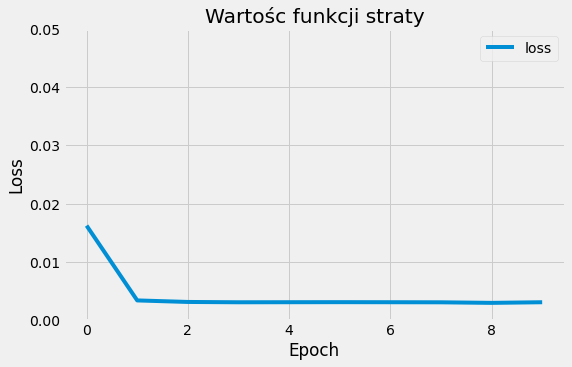

In [29]:
# i jeszcze wykres Loss History
pd.DataFrame(historia.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,.05)
plt.title('Wartośc funkcji straty')
plt.ylabel('Loss')
#plt.legend(['Train', 'Test'], loc='upper left') # nie ma zbioru walidacyjnego więc nie bedzie 
plt.xlabel('Epoch')
plt.show()


Widać, że model uzyskał zbieżność już po kilku epokach! Ponieważ nie jest skomplikowany (tylko jedna zmienna) było to zatem do przewidzenia (w przyszłości pobawię się może w feature enginering i wyliczę średnie, trendy itp. które dodam do modelu przez co nieco go skomplikujemy)

In [51]:
# na wszelki wypadek zapisuję model, zeby nie wgrywać go za każdym razem 
from keras.models import load_model
model.save('lstm_for_c19.h5')


In [52]:
from keras.models import load_model
model = load_model('lstm_for_c19.h5')

In [16]:
# teraz będę bawił się w predykcję. 
trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

TypeError: Singleton array 0.0107599655 cannot be considered a valid collection.

In [30]:
from numpy import newaxis
curr_frame = trainX.copy()
future = []
last_position = len(curr_frame)

for i in range(21):
      # append the prediction to our empty future list
     future.append(model.predict(curr_frame)[last_position-1,0])
      # insert our predicted point to our current frame
     curr_frame = np.append(curr_frame, np.array(future[-1])[newaxis][newaxis,:][newaxis,:,:], axis= 0 )
      # push the frame up one to make it progress into the future
     curr_frame = curr_frame[1:,:,:]
curr_frame = np.reshape(curr_frame, (-1,1))

testPredict = scaler.inverse_transform(curr_frame)
testPredict = testPredict[last_position-21:,:]


In [38]:
import os
IMAGES_PATH = "E:\page ds\pages\ts_covid19" 

def save_fig(file_name, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, file_name + "." + fig_extension)
    print("Zapisywanie rysunku ", file_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

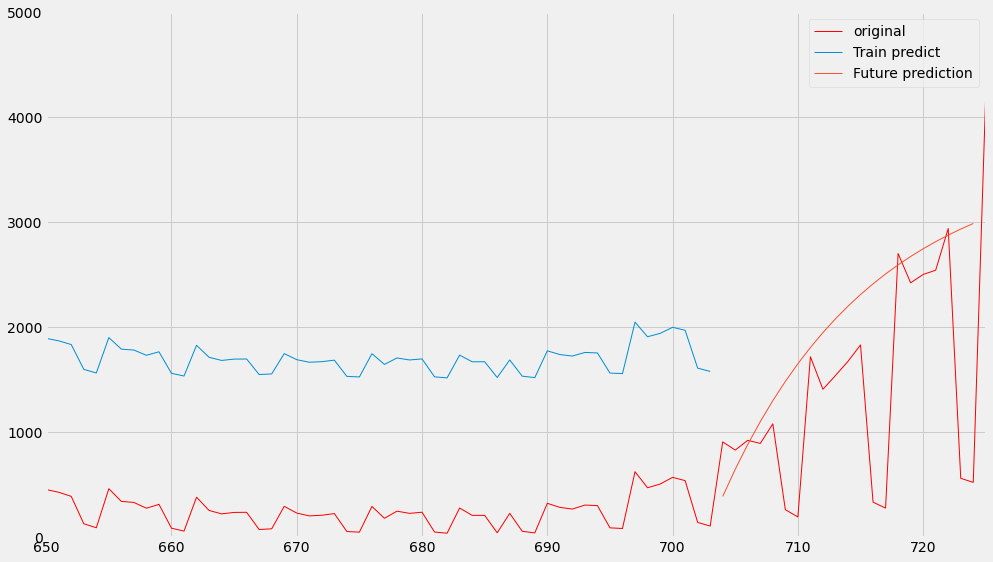

In [42]:
# Wrzucam prognozy na wykres razem z danymi testowymi
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
#trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
trainPredictPlot[0:len(trainPredict), :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict):len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (15,9))
plt.plot(scaler.inverse_transform(dataset), c= 'r', linewidth=1)
plt.plot(trainPredictPlot, linewidth=1)
plt.plot(testPredictPlot, linewidth=1)
#plt.plot(scaler.inverse_transform(test), c='r')
#plt.plot(testPredict)
plt.xlim(650,len(dataset)-1)
plt.ylim(0,5000)
plt.legend(["original", "Train predict", "Future prediction"], loc=0, frameon=True)
plt.savefig(r'E:\page ds\pages\ts_covid19\LSTM_test.png' , format="png", dpi=300)
plt.show()

WOW!! Model może nie wychwytuje dobrze minisezonowości wynikających z weekendowych przerw w informacji o liczbie chorych ale bardzo dobrze wyłapał obecny trend rosnący! (dziś kiedy wykonuję tą analizę mamy 26.07 i dzienna liczba zachorowac wynosi ponad 4200 osób dziennie. Co ciekawe, liczba zgonów z powodu Covid19 przewyższa liczbę zachorowań o około 1000!
